# Data

In [15]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

In [16]:
iris = fetch_ucirepo(id=53)

D1_X = iris.data.features.to_numpy()  # all features are floats without missing values
D1_y = iris.data.targets.to_numpy()  # class of iris plant: Iris Setosa, Iris Versicolour, or Iris Virginica

scaler = MinMaxScaler()
D1_X = scaler.fit_transform(D1_X)

In [17]:
print(f'Features have NaN values: {np.isnan(D1_X).any()}')
print(f'Number of classes: {np.unique(D1_y).size}')

Features have NaN values: False
Number of classes: 3


In [18]:
wine_data = pd.read_csv('data/winequality-red.csv', sep=';')

D2_y = wine_data['quality'].to_numpy().reshape(-1, 1)
D2_X = wine_data.drop('quality', axis=1).to_numpy()

scaler = MinMaxScaler()
D2_X = scaler.fit_transform(D2_X)

# Implementation of K-Nearest Neighbor (KNN)

## Splitting the Data

In [19]:
D1_X_train, D1_X_test, D1_y_train, D1_y_test = train_test_split(D1_X, D1_y, test_size=0.3, random_state=420)

D2_X_train, D2_X_test, D2_y_train, D2_y_test = train_test_split(D2_X, D2_y, test_size=0.3, random_state=420)

## Implementation of KNNClassifier Class

A key difference to the models we have covered so far is the lazy fitting. `Fit` just stores the data points, while the learning happens in the `predict` method.

The method `_get_k_neighbors_indices` is a very naive approach. We just calculate the distance to every training point and return the k closest ones. There are better methods like space-partitioning data structures or approximations like locality sensitive hashing, but these methods are more extensive than intended by the exercise sheet.

In [20]:
class KNNClassifier:
    def __init__(self, k):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """
        Stores the training features X and training targets y.
        :param X: Training Features.
        :param y: Training Targets.
        :return: None.
        """
        self.X_train = X
        self.y_train = y

    def _get_k_neighbors_indices(self, q):
        """
        Determines the top k nearest neighbors for the given query.
        :param q: Query (Data Point).
        :return: Indices of Top k Nearest Neighbors.
        """
        distances = {}
        for i, training_point in enumerate(self.X_train):
            distances[i] = self._distance(training_point, q)

        k_indices = sorted(distances, key=distances.get)[:self.k]

        return k_indices

    @staticmethod
    def _distance(u, v):
        """
        Computes the euclidian distance between vectors u and v.
        :param u: Vector u
        :param v: Vector v
        :return: Euclidian distance between u and v
        """
        return np.sqrt(np.sum((u - v) ** 2))

    def predict(self, X):
        """
        Predicts the class labels for the given input features.
        :param X: Input features.
        :return: Predicted class labels.
        """
        if self.X_train is None or self.y_train is None:
            raise ValueError("You should call fit before predict")

        y_predicted = np.full((X.shape[0], 1), None, dtype=object)
        if type(self.y_train[0][0]) is np.int64:
            y_predicted = np.full((X.shape[0], 1), 0, dtype=np.int64)

        for i, test_point in enumerate(X):
            indices = self._get_k_neighbors_indices(test_point)

            class_count = {}

            for idx in indices:
                predicted_class = self.y_train[idx][0]

                if predicted_class not in class_count:
                    class_count[predicted_class] = 1
                else:
                    class_count[predicted_class] += 1

            best_class = max(class_count, key=class_count.get)
            y_predicted[i][0] = best_class

        return y_predicted

## Quality Measurement of Prediction

We try to estimate a decent value for K.
**Low values** fit the data very closely. This may lead to overfitting.
**High values** lead to a more generalized and smooth model, but may result in underfitting.
For a good balance, we can use the common formula $k = \sqrt{n}$, where n is the number of data points in the training set (https://datascience.stackexchange.com/questions/69415/k-nearest-neighbor-classifier-best-k-value)

As a quality criterion, we use the accuracy of the prediction and the confusion matrix. Using `sklearn.metrics` is very convenient.

In [36]:
def predict_measure(X_train, X_test, y_train, y_test, name, color=plt.cm.Greens):
    k = int(np.sqrt(len(X_train)))
    KNN = KNNClassifier(k=k)
    KNN.fit(X_train, y_train)

    y_pred = KNN.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=color)
    plt.title(f'Confusion Matrix for {name} Dataset (Accuracy: {accuracy:.2%})')
    plt.show()

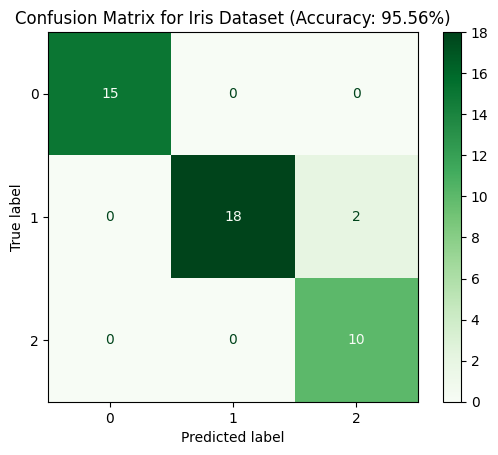

In [37]:
predict_measure(D1_X_train, D1_X_test, D1_y_train, D1_y_test, name='Iris')

For $D_1$, the prediction quality is very strong with **95.56% accuracy** on the 45 test points. Only two misclassifications were made, which shows the model performs well on this simple dataset. The small number of classes (three in total) makes it easier for the KNN model to predict correctly, resulting in this high accuracy.


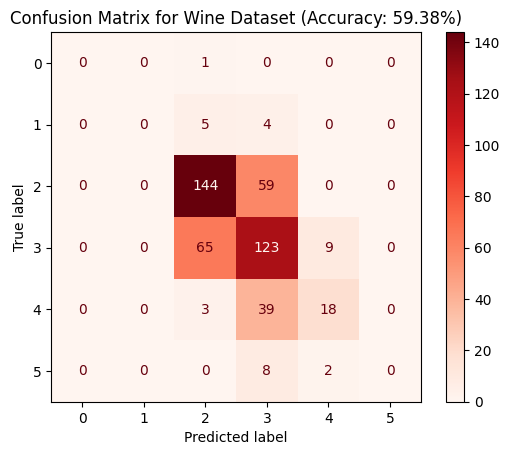

In [38]:
predict_measure(D2_X_train, D2_X_test, D2_y_train, D2_y_test, name='Wine', color=plt.cm.Reds)

For $D_2$, the accuracy is much lower at **59.38%**. The dataset is way larger and more complicated with multiple wine quality classes. All predictions are concentrated on quality levels **2, 3, and 4**. This shows that while KNN can handle simple problems well, it struggles with this kind of complex dataset.


# Optimization and Comparison of KNN Algorithm

## Optimal Value of K

To actually determine the optimal value for K, we can perform **k-fold cross-validation**. We measure the performance by the accuracy of the model.



In [24]:
def determine_optimal_k(X, y, k_values=range(1, 21), n_splits=5):
    fold_size = len(y) // n_splits

    avg_accuracies = []

    for k in k_values:
        accuracies = []

        for fold in range(n_splits):
            start = fold * fold_size
            end = start + fold_size

            X_test = X[start:end]
            y_test = y[start:end]
            X_train = np.concatenate([X[:start], X[end:]], axis=0)
            y_train = np.concatenate([y[:start], y[end:]], axis=0)

            knn = KNNClassifier(k)
            knn.fit(X_train, y_train)

            y_pred = knn.predict(X_test)

            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)

        avg_accuracies.append(np.mean(accuracies))

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, avg_accuracies, marker='o')
    plt.xlabel('Value of K')
    plt.ylabel('Average Accuracy')
    plt.title('K-Value vs. Cross-Validated Accuracy')
    plt.xticks(k_values)
    plt.show()

    return k_values[np.argmax(avg_accuracies)]

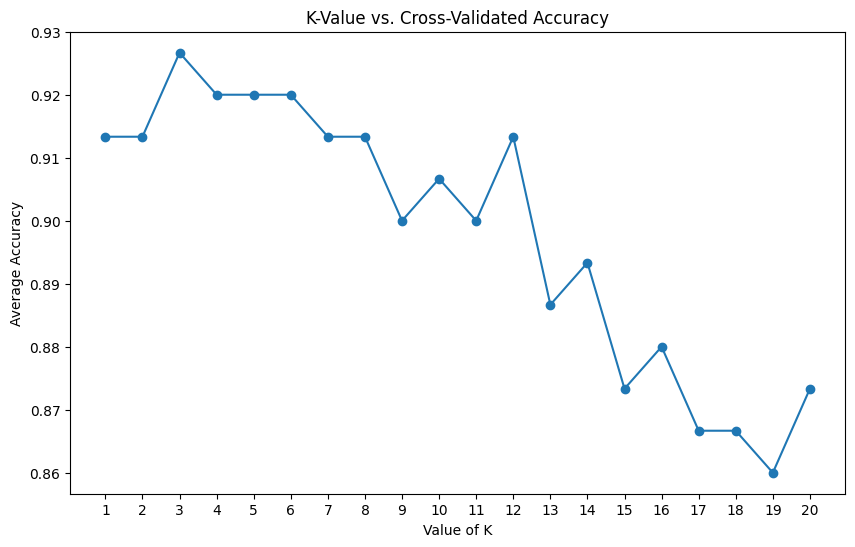

Optimal K for D1: 3 (previous estimation: 12)


In [25]:
D1_optimal_k = determine_optimal_k(D1_X, D1_y)
print(f'Optimal K for D1: {D1_optimal_k} (previous estimation: {int(np.sqrt(len(D1_X)))})')

he optimal $K$ for $D_1$ was found to be **3**, which is much lower than the estimated $\sqrt{n} = 12$. The accuracy increases from $K=1$ to $K=3$, but it drops off when $K$ gets higher. A $K$ this small might overfit a bit, but the simple dataset allows it to still perform well overall.


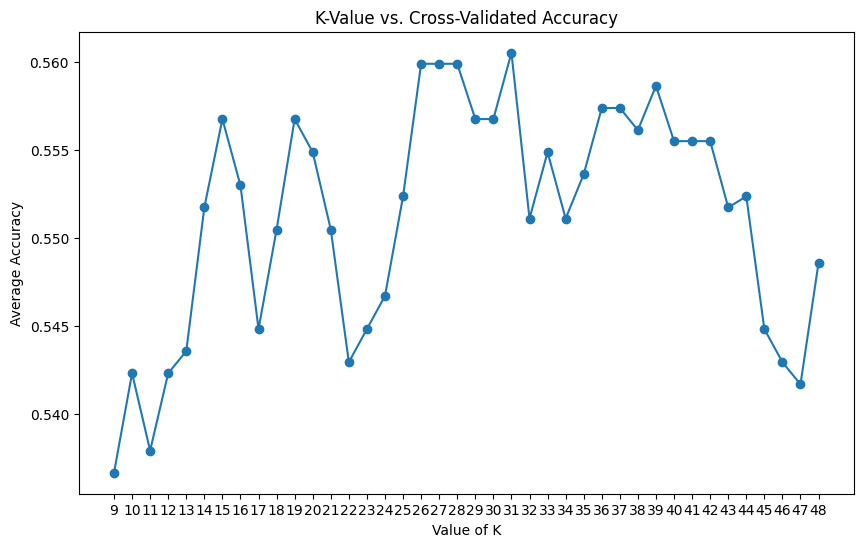

Optimal K for D2: 31 (previous estimation: 39)


In [26]:
D2_optimal_k = determine_optimal_k(D2_X, D2_y, k_values=range(9, 49))
print(f'Optimal K for D2: {D2_optimal_k} (previous estimation: {int(np.sqrt(len(D2_X)))})')

For $D_2$, the best $K$ value is **31**, slightly below the estimated $\sqrt{n} = 39$. Accuracy improves initially as $K$ increases, but the overall accuracy is lower compared to $D_1$, even though a broader range of $K$ was tested. $K=31$ gives a more generalized model, but the complexity of the dataset limits overall accuracy.


## Comparison to Tree-Based Methods

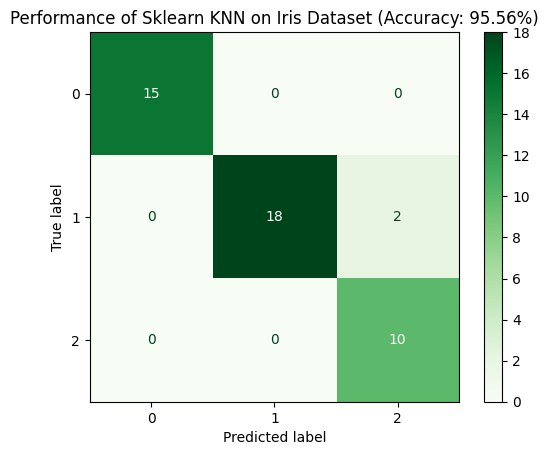

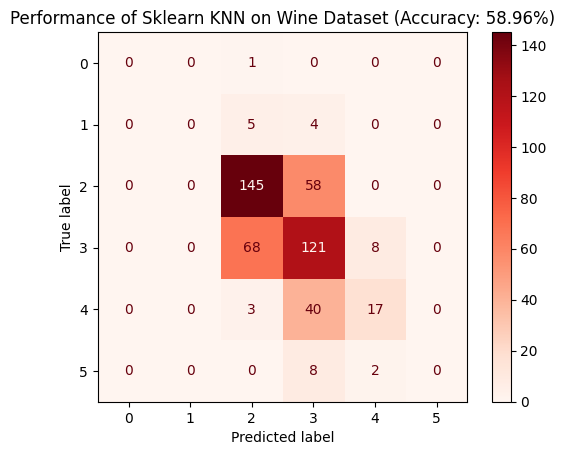

In [27]:
from sklearn.neighbors import KNeighborsClassifier


def predict_measure_sklearn_KNN():
    n_neighbors = int(np.sqrt(len(D1_X_train)))
    KNN = KNeighborsClassifier(n_neighbors=n_neighbors)
    KNN.fit(D1_X_train, D1_y_train.ravel())

    y_pred = KNN.predict(D1_X_test)
    accuracy = accuracy_score(D1_y_test.ravel(), y_pred)

    cm = confusion_matrix(D1_y_test.ravel(), y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Greens)
    plt.title(f'Performance of Sklearn KNN on Iris Dataset (Accuracy: {accuracy:.2%})')
    plt.show()
    plt.close()

    n_neighbors = int(np.sqrt(len(D2_X_train)))
    KNN = KNeighborsClassifier(n_neighbors=n_neighbors)
    KNN.fit(D2_X_train, D2_y_train.ravel())

    y_pred = KNN.predict(D2_X_test)
    accuracy = accuracy_score(D2_y_test.ravel(), y_pred)

    cm = confusion_matrix(D2_y_test.ravel(), y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Reds)
    plt.title(f'Performance of Sklearn KNN on Wine Dataset (Accuracy: {accuracy:.2%})')
    plt.show()
    plt.close()


predict_measure_sklearn_KNN()

We use the `KNeighborsClassifier` from sklearn´and estimate the best k value. We get **very similar** results to our own implementation.

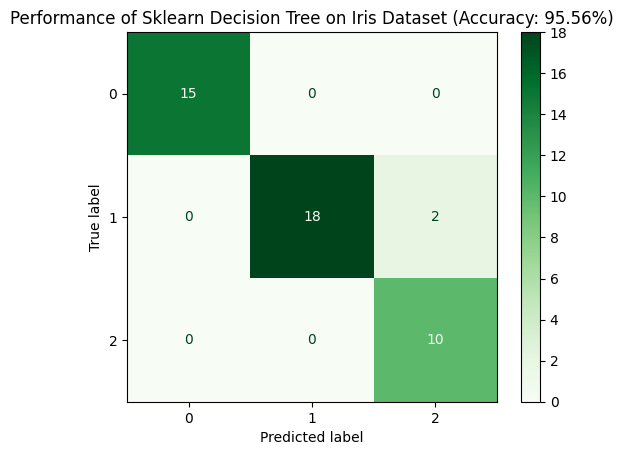

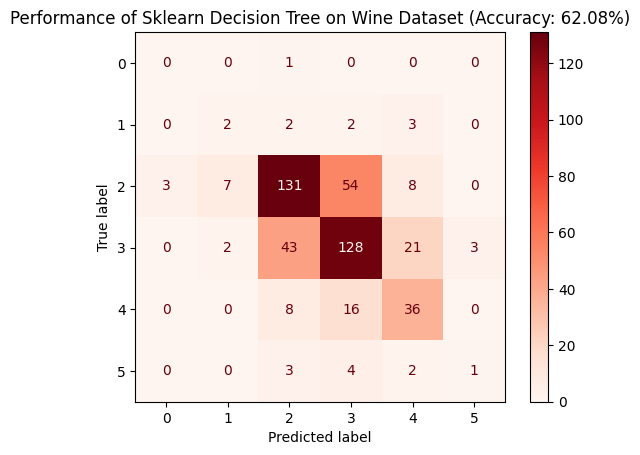

In [39]:
from sklearn.tree import DecisionTreeClassifier


def predict_measure_sklearn_DecisionTree():
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(D1_X_train, D1_y_train.ravel())

    y_pred = decision_tree.predict(D1_X_test)
    accuracy = accuracy_score(D1_y_test.ravel(), y_pred)

    cm = confusion_matrix(D1_y_test.ravel(), y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Greens)
    plt.title(f'Performance of Sklearn Decision Tree on Iris Dataset (Accuracy: {accuracy:.2%})')
    plt.show()
    plt.close()

    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(D2_X_train, D2_y_train.ravel())

    y_pred = decision_tree.predict(D2_X_test)
    accuracy = accuracy_score(D2_y_test.ravel(), y_pred)

    cm = confusion_matrix(D2_y_test.ravel(), y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Reds)
    plt.title(f'Performance of Sklearn Decision Tree on Wine Dataset (Accuracy: {accuracy:.2%})')
    plt.show()
    plt.close()


predict_measure_sklearn_DecisionTree()

For the Iris dataset, both models predict the same results. However, the Decision Tree classifier achieved slightly better accuracy than the KNN model. While KNN performs well on the simple dataset, Decision Tree seems to adapt to decision boundaries more flexibly.

## Determining the Optimal Hyperparameters using Grid Search and Cross-Validation

In [29]:
def compare_knn_decision_tree(X_train, X_test, y_train, y_test, title, color=plt.cm.Greens):
    knn_param_grid = {'n_neighbors': range(1, 21)}
    tree_param_grid = {'max_depth': range(1, 21), 'criterion': ['gini', 'entropy']}

    knn = KNeighborsClassifier()
    knn_grid_search = GridSearchCV(knn, param_grid=knn_param_grid, cv=5, scoring='accuracy')
    knn_grid_search.fit(X_train, y_train.ravel())
    best_knn = knn_grid_search.best_estimator_
    knn_best_params = knn_grid_search.best_params_
    knn_accuracy = accuracy_score(y_test.ravel(), best_knn.predict(X_test))

    decision_tree = DecisionTreeClassifier()
    tree_grid_search = GridSearchCV(decision_tree, tree_param_grid, cv=5, scoring='accuracy')
    tree_grid_search.fit(X_train, y_train.ravel())
    best_tree = tree_grid_search.best_estimator_
    tree_best_params = tree_grid_search.best_params_
    tree_accuracy = accuracy_score(y_test.ravel(), best_tree.predict(X_test))

    knn_cm = confusion_matrix(y_test.ravel(), best_knn.predict(X_test))
    tree_cm = confusion_matrix(y_test.ravel(), best_tree.predict(X_test))

    disp_knn = ConfusionMatrixDisplay(confusion_matrix=knn_cm)
    disp_knn.plot(cmap=color)
    plt.title(f'Confusion Matrix for best KNN on {title} (Accuracy: {knn_accuracy:.2%})')
    plt.show()
    plt.close()
    print('Best KNN Parameters:', knn_best_params)

    disp_tree = ConfusionMatrixDisplay(confusion_matrix=tree_cm)
    disp_tree.plot(cmap=color)
    plt.title(f'Confusion Matrix for best Decision Tree on {title} (Accuracy: {tree_accuracy:.2%})')
    plt.show()
    plt.close()
    print('Best Decision Tree Parameters:', tree_best_params)

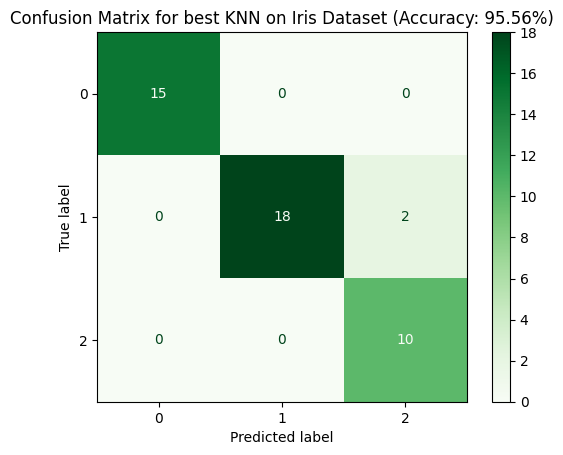

Best KNN Parameters: {'n_neighbors': 3}


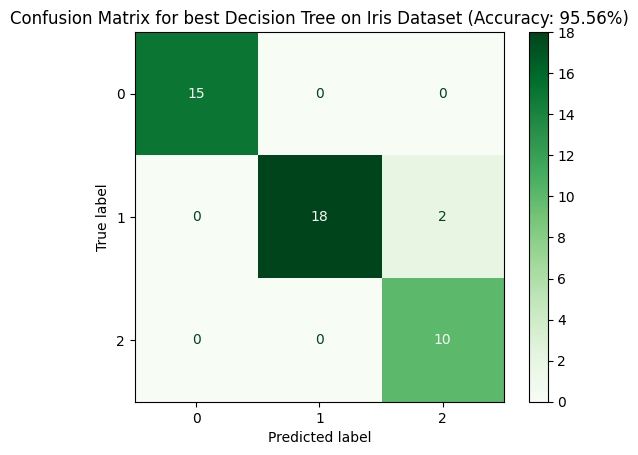

Best Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 5}


In [30]:
compare_knn_decision_tree(D1_X_train, D1_X_test, D1_y_train, D1_y_test, 'Iris Dataset')

Both KNN and the Decision Tree provide identical predictions. For this specific dataset, the two algorithms found similar patterns and decision boundaries, resulting in equivalent classification outcomes.

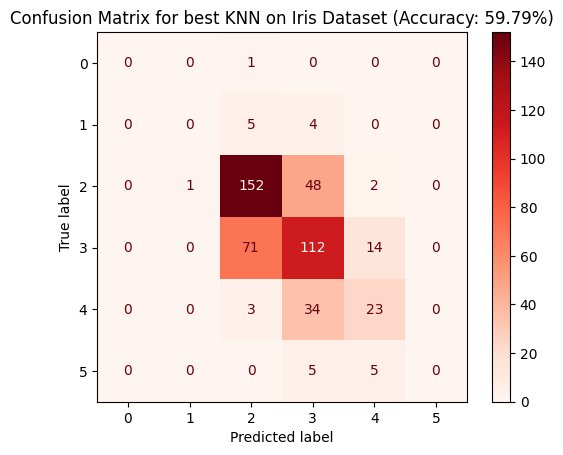

Best KNN Parameters: {'n_neighbors': 14}


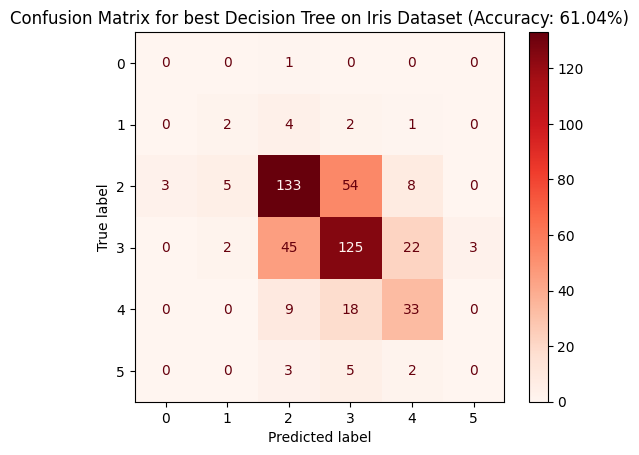

Best Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 20}


In [31]:
compare_knn_decision_tree(D2_X_train, D2_X_test, D2_y_train, D2_y_test, 'Iris Dataset', color=plt.cm.Reds)

With further optimization, the KNN model shows slight improvement in accuracy. However, the Decision Tree is unable to improve its performance beyond the initial call, it might have already reached its potential for this dataset.
